# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [62]:
# Load the libraries as required.
%load_ext dotenv
%dotenv "C:\\Users\\Catren-PC\\Desktop\\DSI\\production\\05_src\.env"

import os
import sys
sys.path.append(os.getenv('SRC_DIR'))

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression

In [21]:
os.chdir("C:\\Users\\Catren-PC\\Desktop\\DSI\\production\\")

In [22]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('./05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [23]:
# Get all features except target column
X = fires_dt.drop(columns='area')

# Target series (only the target column)
y = fires_dt['area']

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [151]:
#Identify the numeric columns to be transformed
num_cols = ['ffmc', 'dmc', 'dc', 'isi', 
            'temp', 'rh', 'wind', 'rain']

#Identify the categorical columns
cat_cols = ['month', 'day']

#Create preproc1 transformer
preproc1 = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), num_cols), 
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)]
        , remainder='passthrough' #includes coord_x, coord_y, area
    )

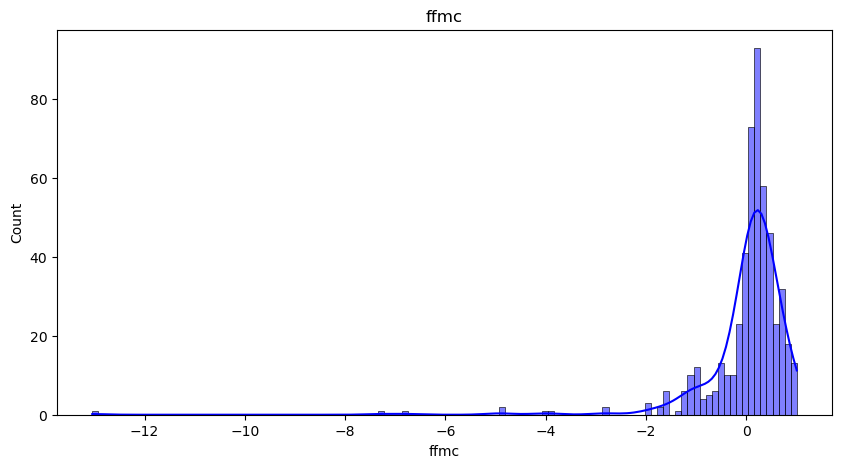

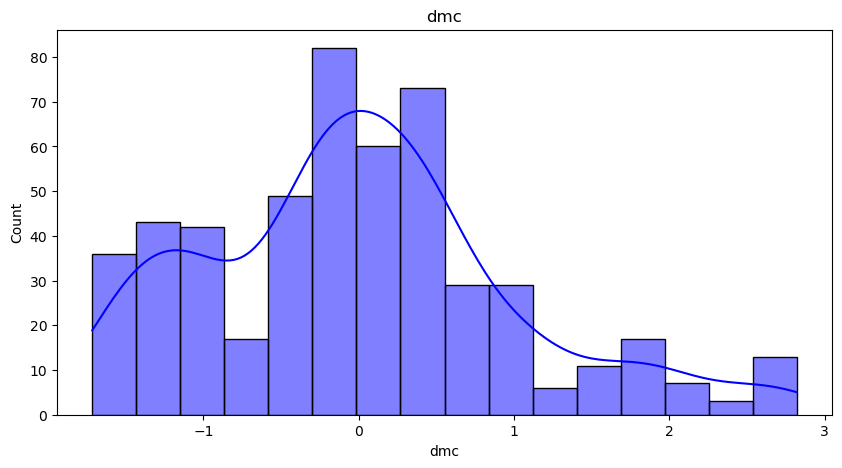

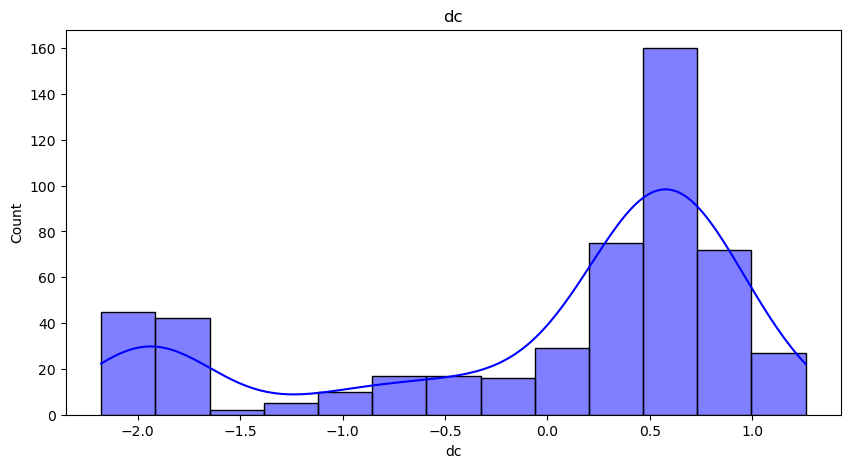

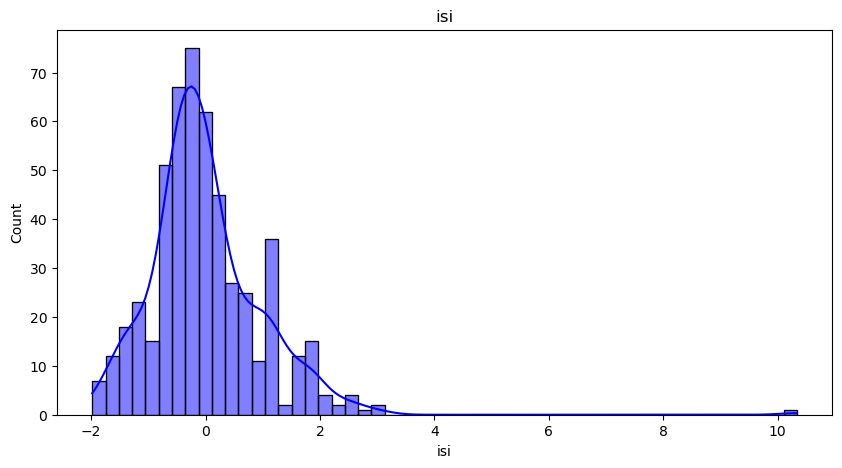

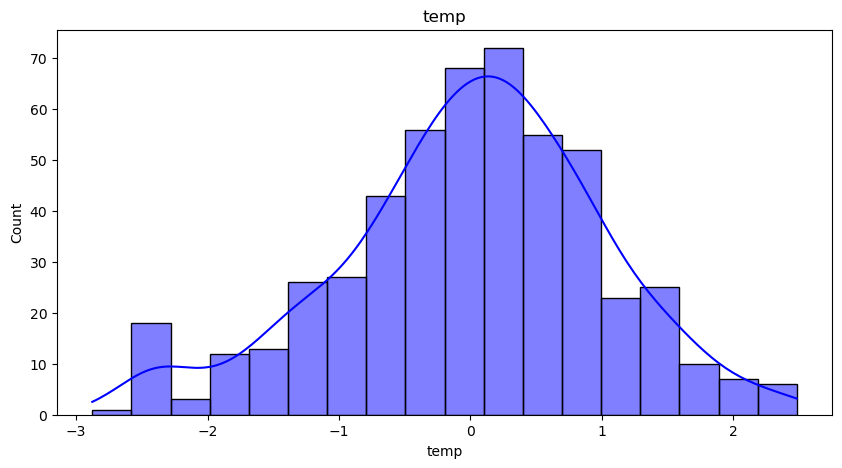

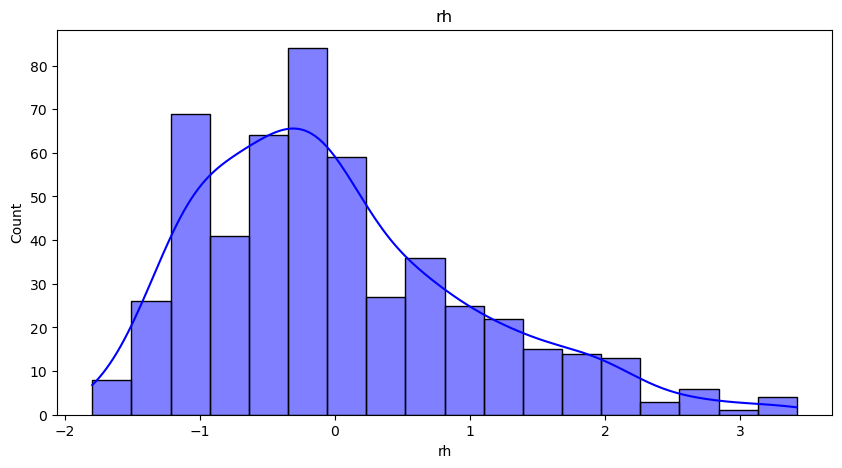

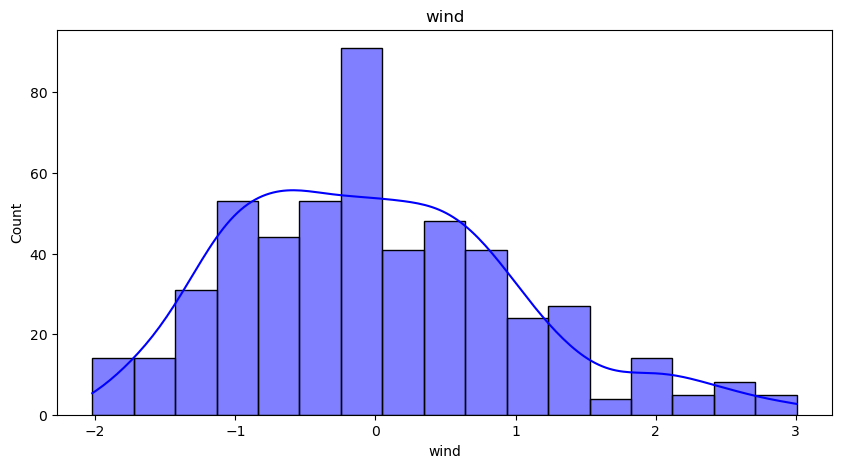

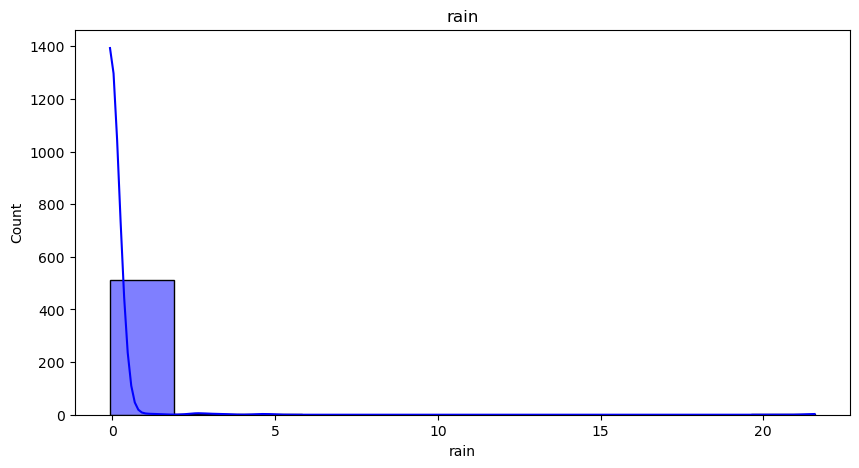

In [152]:
proc1data = preproc1.fit_transform(fires_dt)

# Access transformer for num_cols
numeric_preproc1 = preproc1.transformers_[0][1]

# Get the feature names
numeric_features = numeric_preproc1.get_feature_names_out(num_cols)

#Extract the numeric columns
numeric_data = proc1data[:, :len(numeric_features)]

# Convert the numeric data to a DataFrame
numeric_df = pd.DataFrame(numeric_data, columns=numeric_features)

# Scaled numeric data distributions
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(numeric_df[col], kde=True, color="blue", label=col)
    plt.title(f"{col}")
    plt.show()

### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [154]:
num_cols_std = [col for col in num_cols if col not in ['ffmc', 'isi']]
num_cols_std

['dmc', 'dc', 'temp', 'rh', 'wind', 'rain']

In [155]:
#Create preproc2, transform two numeric vars
preproc2= ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), num_cols_std), 
        ('num_yj', PowerTransformer(method= 'yeo-johnson'), ['ffmc','isi']),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols) ]
        , remainder='passthrough'
    )

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [156]:
from sklearn.linear_model import Ridge

# Pipeline A = preproc1 + baseline model
pipe_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Ridge())
])

pipe_A

c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaled',
                                                  StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat_onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [157]:
# Pipeline B = preproc2 + baseline model
pipe_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge())
])

pipe_B

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaled',
                                                  StandardScaler(),
                                                  ['dmc', 'dc', 'temp', 'rh',
                                                   'wind', 'rain']),
                                                 ('num_yj', PowerTransformer(),
                                                  ['ffmc', 'isi']),
                                                 ('cat_onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [158]:
from sklearn.ensemble import RandomForestRegressor

# Pipeline C = preproc1 + advanced model
pipe_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor())
])

pipe_C

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaled',
                                                  StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat_onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [159]:
# Pipeline D = preproc2 + advanced model
pipe_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor())
])

pipe_D

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaled',
                                                  StandardScaler(),
                                                  ['dmc', 'dc', 'temp', 'rh',
                                                   'wind', 'rain']),
                                                 ('num_yj', PowerTransformer(),
                                                  ['ffmc', 'isi']),
                                                 ('cat_onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

<h4> Pipeline A: preproc1 + baseline model

In [171]:
#Cross-validate Pipeline A using train test split
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'explained_variance']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

res_pipeA_dict = cross_validate(pipe_A, X_train, Y_train, cv = 5, scoring = scoring)

res_pipeA = pd.DataFrame(res_pipeA_dict).assign(experiment = 1)

res_pipeA.mean()

fit_time                               0.037996
score_time                             0.015307
test_r2                               -0.302214
test_neg_mean_absolute_error         -18.214672
test_neg_mean_squared_error        -2227.377087
test_neg_root_mean_squared_error     -41.091930
test_explained_variance               -0.261221
experiment                             1.000000
dtype: float64

In [172]:
#Get all params of pipeline A
pipe_A.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num_scaled', StandardScaler(),
                                    ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                     'wind', 'rain']),
                                   ('cat_onehot',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['month', 'day'])])),
  ('regressor', Ridge())],
 'verbose': False,
 'preprocessing': ColumnTransformer(remainder='passthrough',
                   transformers=[('num_scaled', StandardScaler(),
                                  ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                   'wind', 'rain']),
                                 ('cat_onehot',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['month', 'day'])]),
 'regressor': Ridge(),
 'preprocessing__fo

In [195]:
#Set up ridge regression tuning parameters
param_grid_ridge = {
    'regressor__alpha': [0.1, 1.0, 10, 100],
    'regressor__max_iter': [1000, 2000]
}

In [ ]:
grid_cv_A = GridSearchCV(
    estimator= pipe_A, 
    param_grid= param_grid_ridge, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_root_mean_squared_error",
    return_train_score=True
     )

grid_cv_A.fit(X_train, Y_train)

c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_scaled',
                                                                         StandardScaler(),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.1, 1.0, 10, 100],
                         'regressor__max_iter': [1000, 2000]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error', 'explained_variance'])

In [213]:
#Convert GridSearch results into dataframe
resA = grid_cv_A.cv_results_
resA = pd.DataFrame(resA)

resA[['param_regressor__alpha', 'param_regressor__max_iter', 
       'mean_train_r2','mean_test_r2',
      'mean_train_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error','rank_test_neg_root_mean_squared_error']]

#Greater alpha = 10 gave the best neg RMSE -40.69, regardless of max iter (1000 vs 2000)


,param_regressor__alpha,param_regressor__max_iter,mean_train_r2,mean_test_r2,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.1,1000,0.062116,-0.313287,-43.440817,-41.162963,7
1,0.1,2000,0.062116,-0.313287,-43.440817,-41.162963,7
2,1.0,1000,0.060475,-0.302214,-43.474763,-41.091930,5
3,1.0,2000,0.060475,-0.302214,-43.474763,-41.091930,5
4,10.0,1000,0.053525,-0.258444,-43.627521,-40.690471,3
5,10.0,2000,0.053525,-0.258444,-43.627521,-40.690471,3
6,100.0,1000,0.041062,-0.144788,-43.899701,-39.500190,1
7,100.0,2000,0.041062,-0.144788,-43.899701,-39.500190,1


In [231]:
grid_cv_A.best_params_

{'regressor__alpha': 100, 'regressor__max_iter': 1000}

<h4> Pipeline B: preproc2 + baseline model

In [176]:
#Cross-validate Pipeline B using train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

res_pipeB_dict = cross_validate(pipe_B, X_train, Y_train, cv = 5, scoring = scoring)

res_pipeB = pd.DataFrame(res_pipeB_dict).assign(experiment = 1)

res_pipeB.mean()

fit_time                               0.032223
score_time                             0.018408
test_r2                               -0.298350
test_neg_mean_absolute_error         -18.143474
test_neg_mean_squared_error        -2224.285259
test_neg_root_mean_squared_error     -41.061146
test_explained_variance               -0.257107
experiment                             1.000000
dtype: float64

In [206]:
grid_cv_B = GridSearchCV(
    estimator= pipe_B, 
    param_grid= param_grid_ridge, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_root_mean_squared_error",
    return_train_score=True)

grid_cv_B.fit(X_train, Y_train)

c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_scaled',
                                                                         StandardScaler(),
                                                                         ['dmc',
                                                                          'dc',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('num_yj',
                                                                         PowerTransformer(),
                                                                         ['ffmc',
                                                                          'isi']),
                                                                        ('cat_onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.1, 1.0, 10, 100],
                         'regressor__max_iter': [1000, 2000]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error', 'explained_variance'])

In [207]:
resB = grid_cv_B.cv_results_
resB = pd.DataFrame(resB)
resB[['param_regressor__alpha', 'param_regressor__max_iter', 
      'mean_train_r2', 'mean_test_r2',
      'mean_train_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error','rank_test_neg_root_mean_squared_error']]

,param_regressor__alpha,param_regressor__max_iter,mean_train_r2,mean_test_r2,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.1,1000,0.061610,-0.307736,-43.449643,-41.120971,7
1,0.1,2000,0.061610,-0.307736,-43.449643,-41.120971,7
2,1.0,1000,0.059893,-0.298350,-43.484778,-41.061146,5
3,1.0,2000,0.059893,-0.298350,-43.484778,-41.061146,5
4,10.0,1000,0.052812,-0.259508,-43.639969,-40.697783,3
5,10.0,2000,0.052812,-0.259508,-43.639969,-40.697783,3
6,100.0,1000,0.040784,-0.149887,-43.903710,-39.548650,1
7,100.0,2000,0.040784,-0.149887,-43.903710,-39.548650,1


In [230]:
grid_cv_B.best_params_

{'regressor__alpha': 100, 'regressor__max_iter': 1000}

<h4> Pipeline C: preproc 1 + advanced model

In [179]:
#Cross-validate Pipeline C using train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

res_pipeC_dict = cross_validate(pipe_C, X_train, Y_train, cv = 5, scoring = scoring)

res_pipeC = pd.DataFrame(res_pipeC_dict).assign(experiment = 1)

res_pipeC.mean()

fit_time                               0.377438
score_time                             0.018671
test_r2                               -1.967462
test_neg_mean_absolute_error         -20.708625
test_neg_mean_squared_error        -2963.453701
test_neg_root_mean_squared_error     -50.097589
test_explained_variance               -1.695256
experiment                             1.000000
dtype: float64

In [180]:
#Get all params of pipeline C
pipe_C.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num_scaled', StandardScaler(),
                                    ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                     'wind', 'rain']),
                                   ('cat_onehot',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['month', 'day'])])),
  ('regressor', RandomForestRegressor())],
 'verbose': False,
 'preprocessing': ColumnTransformer(remainder='passthrough',
                   transformers=[('num_scaled', StandardScaler(),
                                  ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                   'wind', 'rain']),
                                 ('cat_onehot',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['month', 'day'])]),
 'regressor': RandomForest

In [217]:
#Set up random forest regression tuning parameters
param_grid_rf = {
    'regressor__max_depth' : [10, 20],
    'regressor__min_samples_leaf': [1, 10],
    'regressor__min_samples_split': [2, 20]
}

In [218]:
#Perform grid search
grid_cv_C = GridSearchCV(
    estimator= pipe_C, 
    param_grid= param_grid_rf, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_root_mean_squared_error"
    , return_train_score=True)

grid_cv_C.fit(X_train, Y_train)

c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_scaled',
                                                                         StandardScaler(),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [10, 20],
                         'regressor__min_samples_leaf': [1, 10],
                         'regressor__min_samples_split': [2, 20]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error', 'explained_variance'])

In [224]:
resC = grid_cv_C.cv_results_
resC = pd.DataFrame(resC)
resC[['param_regressor__max_depth','param_regressor__min_samples_leaf', 'param_regressor__min_samples_split', 
      'mean_train_r2','mean_test_r2',
    'mean_test_neg_root_mean_squared_error','rank_test_neg_root_mean_squared_error']]

,param_regressor__max_depth,param_regressor__min_samples_leaf,param_regressor__min_samples_split,mean_train_r2,mean_test_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,10,1,2,0.797598,-1.860416,-48.397076,8
1,10,1,20,0.280160,-0.395792,-41.363083,5
2,10,10,2,0.136185,-0.223265,-39.843950,1
3,10,10,20,0.139359,-0.277848,-40.199841,3
4,20,1,2,0.814327,-1.429458,-47.265637,7
5,20,1,20,0.271705,-0.515148,-41.828503,6
6,20,10,2,0.133182,-0.224669,-39.861309,2
7,20,10,20,0.134507,-0.315195,-40.362322,4


In [229]:
grid_cv_C.best_params_

{'regressor__max_depth': 10,
 'regressor__min_samples_leaf': 10,
 'regressor__min_samples_split': 2}

<h4> Pipeline D: preproc2 + advanced model

In [184]:
#Cross-validate Pipeline D using train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

res_pipeD_dict = cross_validate(pipe_D, X_train, Y_train, cv = 5, scoring = scoring)

res_pipeD = pd.DataFrame(res_pipeD_dict).assign(experiment = 1)

res_pipeD.mean()

fit_time                               0.395331
score_time                             0.019260
test_r2                               -2.008827
test_neg_mean_absolute_error         -20.624410
test_neg_mean_squared_error        -2945.376620
test_neg_root_mean_squared_error     -49.828859
test_explained_variance               -1.730667
experiment                             1.000000
dtype: float64

In [220]:
#Perform grid search using hyperparameter values specified above
grid_cv_D = GridSearchCV(
    estimator= pipe_D, 
    param_grid= param_grid_rf, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_root_mean_squared_error",
    return_train_score=True
    )

grid_cv_D.fit(X_train, Y_train)

c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_scaled',
                                                                         StandardScaler(),
                                                                         ['dmc',
                                                                          'dc',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('num_yj',
                                                                         PowerTransformer(),
                                                                         ['ffmc',
                                                                          'isi']),
                                                                        ('cat_onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [10, 20],
                         'regressor__min_samples_leaf': [1, 10],
                         'regressor__min_samples_split': [2, 20]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error', 'explained_variance'])

In [225]:
resD = grid_cv_D.cv_results_
resD = pd.DataFrame(resD)
resD[['param_regressor__max_depth', 'param_regressor__min_samples_leaf', 'param_regressor__min_samples_split', 
      'mean_train_r2', 'mean_test_r2',
    'mean_test_neg_root_mean_squared_error','rank_test_neg_root_mean_squared_error']]

,param_regressor__max_depth,param_regressor__min_samples_leaf,param_regressor__min_samples_split,mean_train_r2,mean_test_r2,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,10,1,2,0.805075,-1.630845,-48.008063,7
1,10,1,20,0.273635,-0.442036,-41.613714,5
2,10,10,2,0.137629,-0.220315,-39.930604,1
3,10,10,20,0.138134,-0.246996,-40.096441,3
4,20,1,2,0.821199,-2.098323,-49.725524,8
5,20,1,20,0.270341,-0.587021,-42.263285,6
6,20,10,2,0.134829,-0.258195,-40.084294,2
7,20,10,20,0.135417,-0.267348,-40.230268,4


In [228]:
grid_cv_D.best_params_

{'regressor__max_depth': 10,
 'regressor__min_samples_leaf': 10,
 'regressor__min_samples_split': 2}

# Evaluate

+ Which model has the best performance?

Pipeline A: -41.091930; the best neg RMSE -39.500190 was with alpha= 100 and max iter=1000
<br>
Pipeline B: -41.061146; the best neg RMSE -39.548650 was with alpha= 100 and max iter=1000
<br>
Pipeline C: -50.097589; the best neg RMSE was -39.843950 with max depth=10, min leaf samples=10, and min split samples= 2
<br>
Pipeline D: -49.828859; the best neg RMSE was -39.930604 with max depth=10, min leaf samples=10, and min split samples= 2
<br><br>
Purely judging on the neg RMSE, pipeline B was the best performing of the four, and tuning the alpha reduced the RMSE even further. Comparing pipeline A vs. B and pipeline C vs. D, Yeo-Johnson tranforming columns *FFMC* and *ISI* improved the RMSE very little. The Ridge regression appears to fit better than Random Forest regression based on RMSE. Tuning the alpha improve the Ridge regression RMSE a little. However, the difference between the train and test R2 indicate overfitting (for all four models tested above).

# Export

+ Save the best performing model to a pickle file.

In [236]:
import pickle

best_model = grid_cv_B.best_estimator_

best_model_pkl= "best_model_pipeB.pkl" 

with open(best_model_pkl, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved to {os.path.abspath(best_model_pkl)}")


Best model saved to C:\Users\Catren-PC\Desktop\DSI\production\best_model_pipeB.pkl


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [240]:
import shap

data_transform = best_model.named_steps['preprocessing'].transform(X_test)

#explain the linear ridge regression that was done in Pipeline B
explainer = shap.explainers.Linear(
    best_model.named_steps['regressor'], 
    data_transform,
    feature_names = best_model.named_steps['preprocessing'].get_feature_names_out())

shap_values = explainer(data_transform)

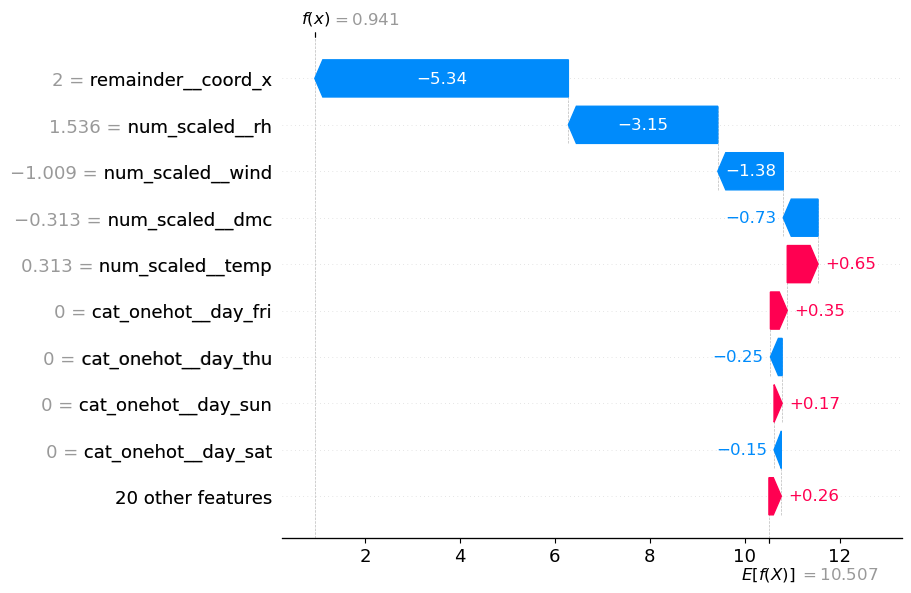

In [245]:
shap.plots.waterfall(shap_values[9])

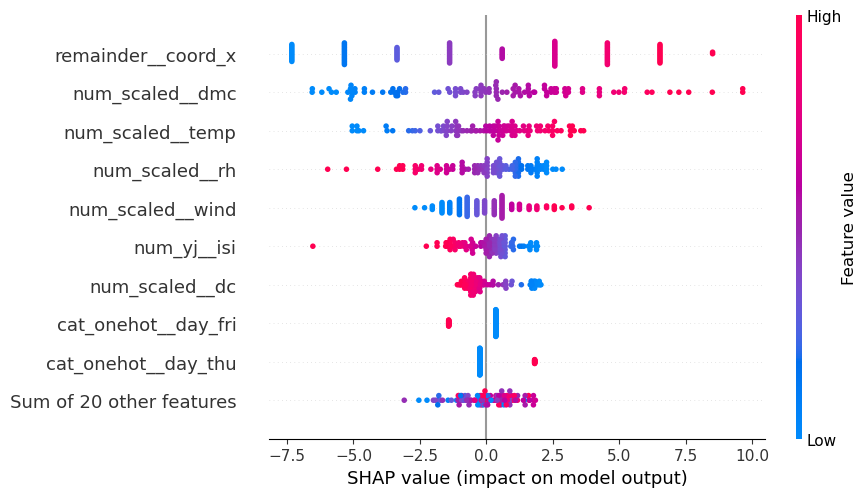

In [243]:
shap.plots.beeswarm(shap_values)

Selecting the 10th observation in the test set, the waterfall plot shows that coord_x, rh, and wind are 3 most important features. However, the beeswarm plot shows that overall, coord_x, dmc, and temp are the most important features for modeling fire area.

I'd first consider removing features with the lowest shap values such as FFMC, rain, coord_y, month. I'd also remove highly collinear columns by calculating VIF. To validate the context of feature selection, I'd consult with a subject matter expert on forest fires.
<br> To see if the features enhance model performance, I could run the model again with those features omitted and compare impact on the scoring metrics.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.